## **Simple Blog Agent**


In [ ]:
from langgraph.graph import START, END, StateGraph
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from typing import TypedDict

In [ ]:
class BlogState(TypedDict):
    topic: str
    outline: str
    final_blog: str
    blog_score: float
    feedback: str

In [ ]:
# ---------------- STRUCTURED OUTPUT ----------------

class BlogEvaluation(BaseModel):
    score: float = Field(..., ge=0.0, le=10.0)
    feedback: str = Field(...,
                          description="What needs improvement in the blog")

In [12]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud", temperature=0.7)
llm_judge = ChatOllama(model="deepseek-v3.1:671b-cloud", temperature=0.0)

In [13]:
# ---------------- NODES ----------------

def create_outline(state: BlogState) -> BlogState:
    prompt = f"Create a detailed blog outline on: {state['topic']}"
    state["outline"] = llm.invoke(prompt).content
    return state


def create_blog(state: BlogState) -> BlogState:
    outline = state["outline"]
    feedback = state.get("feedback", "")

    if feedback:
        prompt = f"""
Improve the blog using this feedback:

Feedback:
{feedback}

Blog outline:
{outline}

Rewrite the blog better.
"""
    else:
        prompt = f"""
Write a detailed blog based on this outline:

{outline}
"""

    state["final_blog"] = llm.invoke(prompt).content
    return state


def score_blog(state: BlogState) -> BlogState:
    prompt = f"""
Evaluate the blog based on how well it follows the outline.

Outline:
{state['outline']}

Blog:
{state['final_blog']}

Return JSON only:
{{"score": number between 0 and 10, "feedback": "how to improve"}}
"""

    judge = llm_judge.with_structured_output(BlogEvaluation)
    result = judge.invoke(prompt)

    state["blog_score"] = result.score
    state["feedback"] = result.feedback

    return state

In [14]:
# ---------------- ROUTER ----------------
# if blog score is less than 7, go back to create_blog node

def blog_optimizer(state: BlogState) -> str:
    if state["blog_score"] < 7.0:
        return "optimize blog"
    return "end"

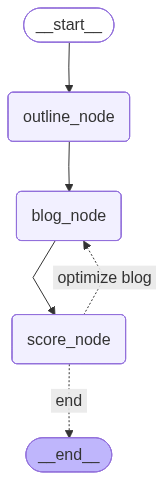

In [15]:
# ---------------- GRAPH ----------------

graph = StateGraph(BlogState)

graph.add_node("outline_node", create_outline)
graph.add_node("blog_node", create_blog)
graph.add_node("score_node", score_blog)

graph.add_edge(START, "outline_node")
graph.add_edge("outline_node", "blog_node")
graph.add_edge("blog_node", "score_node")

graph.add_conditional_edges(
    source="score_node",
    path=blog_optimizer,
    path_map={
        "optimize blog": "blog_node",
        "end": END
    }
)
graph.add_edge("blog_node", END)

app = graph.compile()
app

In [16]:
# response = app.invoke({
#     "topic": "Cats vs Dogs: Which Pet Is Better?"
# })

# print("\nFINAL BLOG:\n", response["final_blog"])
# print("\nSCORE:", response["blog_score"])
# print("\nLAST FEEDBACK:\n", response["feedback"])